# 毕业论文`GRAD`
## `CMAQ`模拟效果验证

---
*@author: Evan*\
*@date: 2023-11-10*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask
import ModelEvalLib as me

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 读取模拟数据

In [2]:
simvar = 'O3'
obsvar = 'O3'

ds = xr.open_dataset(datadir + f'processed/Sep_2021/Sep_2021_chem.nc')
data_sim = ds[simvar][:,0,:,:]

shp = gpd.read_file(shp_PRD_adm)
lon = data_sim.longitude
lat = data_sim.latitude
mask    = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('y','x'))
masked_sim  = data_sim.where(mask_da)
mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)

sim = mean_sim.rolling(time=8).mean().resample(time='D').max()
# sim = mean_sim.resample(time='D').mean()
sim.shape

(30,)

## 读取观测数据

In [3]:
df = pd.read_excel(obsSep + f'site_{obsvar}_2021.xlsx',index_col=0)
mean_obs = df.mean(axis=1,skipna=True)
obs = mean_obs.rolling(8).mean().resample('D').max()
obs.shape

(30,)

## 计算统计参数

In [4]:
# 使用逐小时值计算统计量，观测序列需对空值做填充
mean_obs.interpolate(method='linear',inplace=True)

In [5]:
metrics = me.CalculateMetrics(mean_obs,mean_sim)

mb   = metrics.get_mb().values
r    = metrics.get_r()
rmse = metrics.get_rmse().values
ioa  = metrics.get_ioa().values
nmb  = metrics.get_nmb().values
nme  = metrics.get_nme().values

print('MB  : ',mb,'\nR   : ',r,'\nRMSE: ',rmse,'\nIOA : ',ioa,'\nNMB : ',nmb,'\nNME : ',nme)

MB  :  28.537668078028194 
R   :  0.8724651225216121 
RMSE:  38.931286866993695 
IOA :  0.8687642091172663 
NMB :  40.86476326524755 
NME :  55.74799654552092


## 绘制折线图

日均值/MDA8

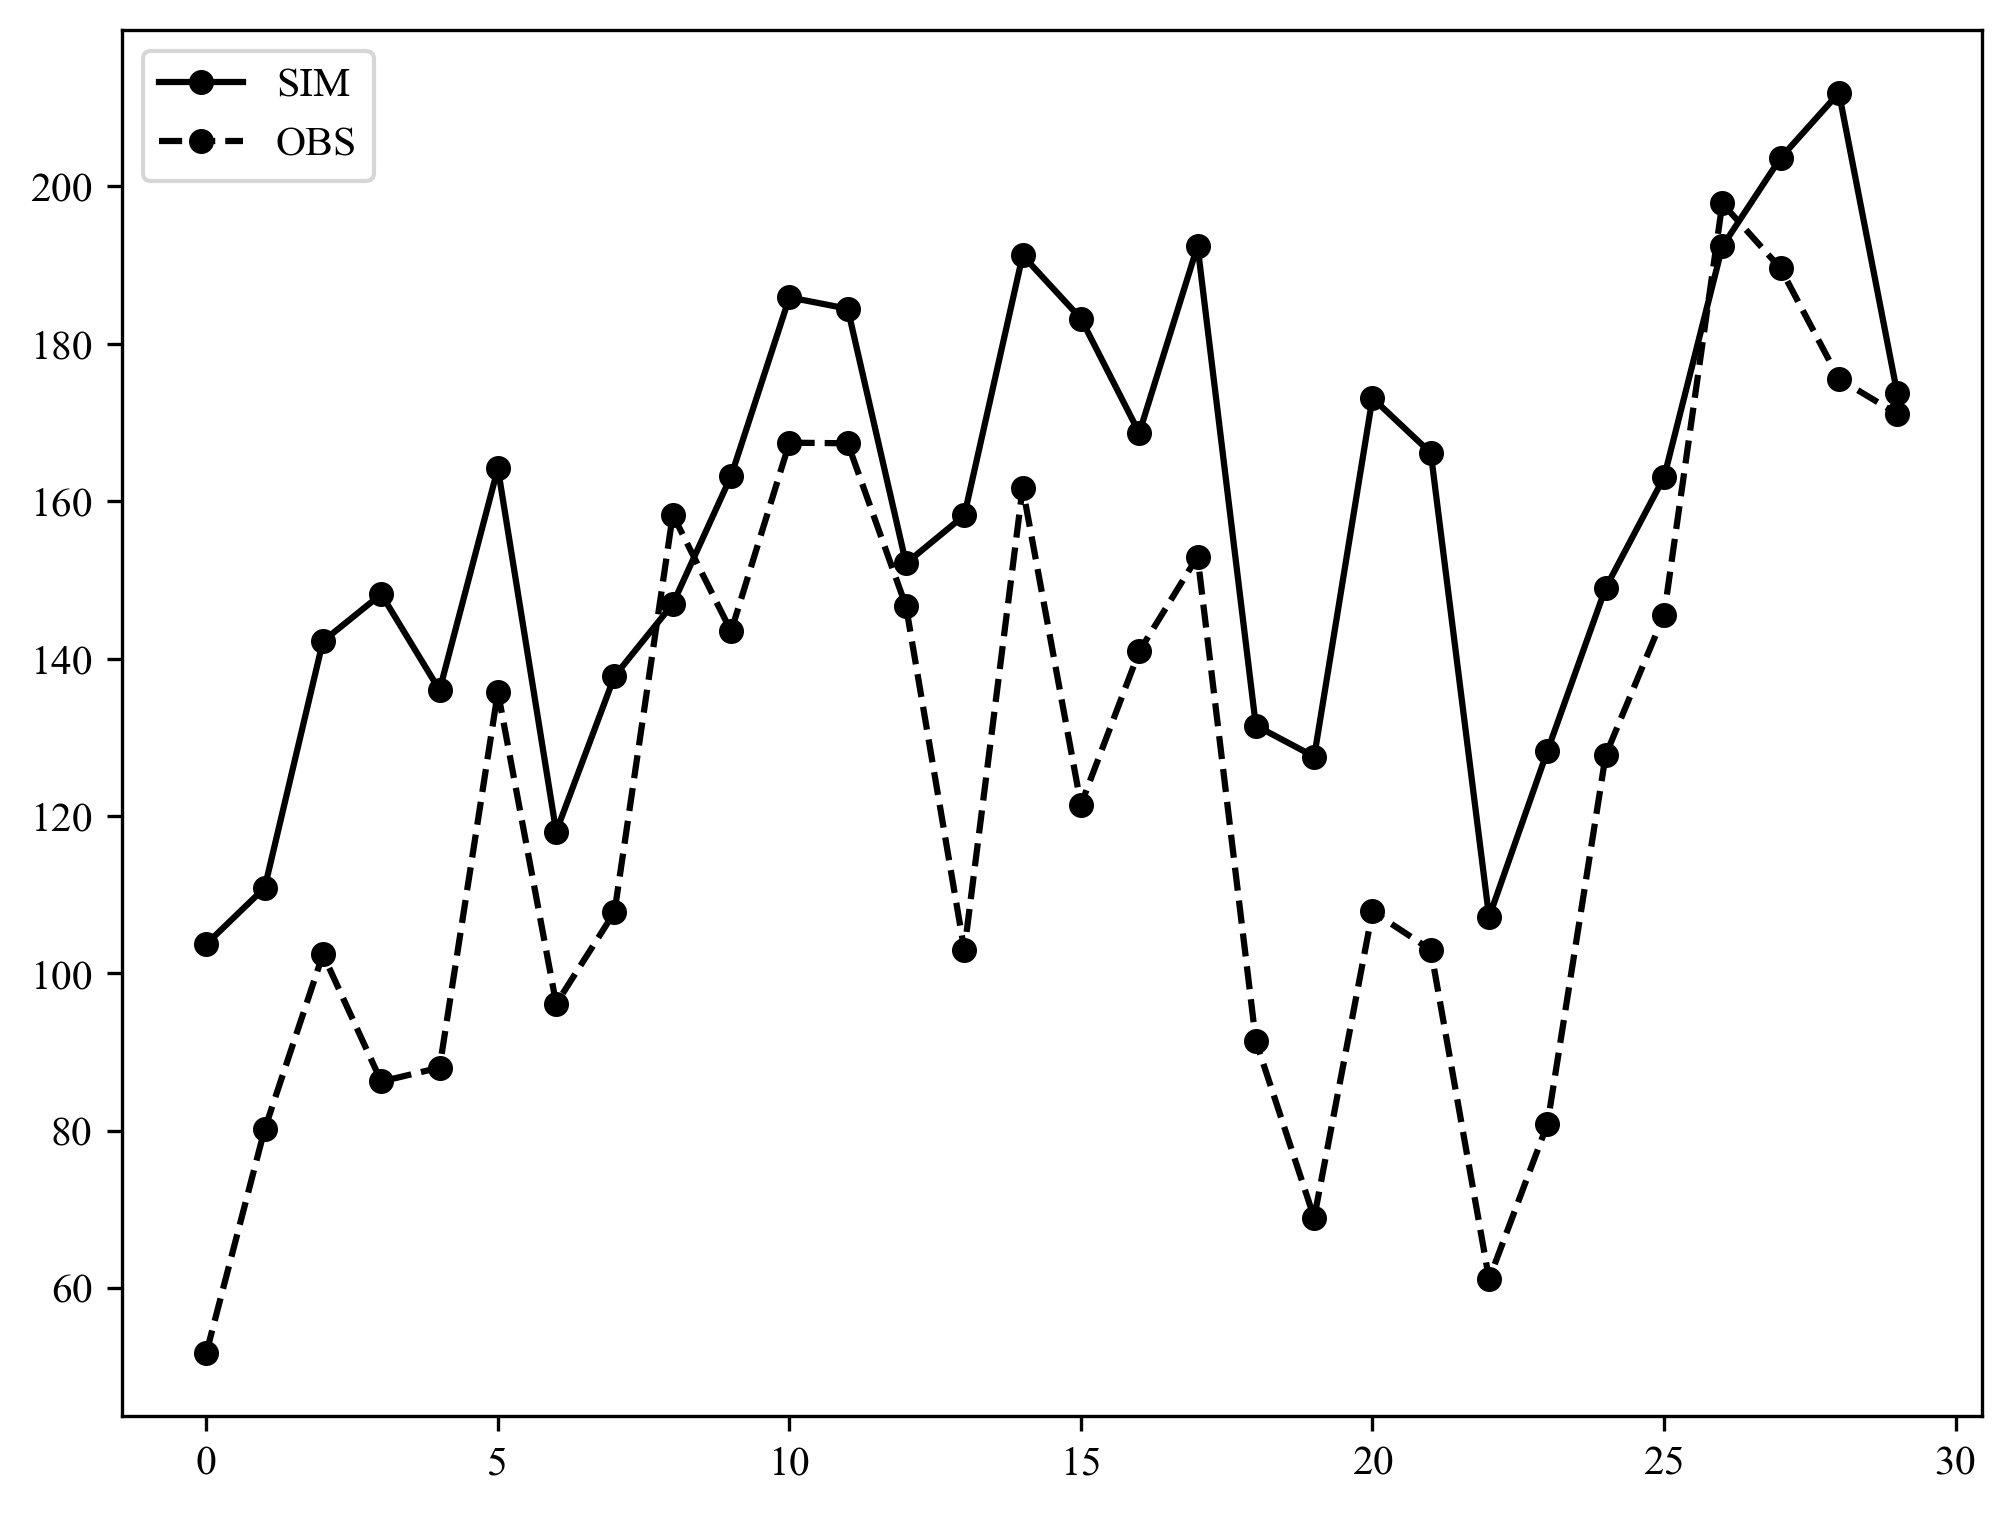

In [6]:
fig = plt.figure(figsize=(8,6),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,np.size(obs,0),1)
ax.plot(xx,sim,color='k',label='SIM',linestyle='-', marker='.',markersize=10)
ax.plot(xx,obs,color='k',label='OBS',linestyle='--',marker='.',markersize=10)

ax.legend(loc=2)
plt.show()

逐小时值

In [7]:
df = pd.read_excel(obsSep + f'site_{obsvar}_2021.xlsx',index_col=0)
mean_obs = df.mean(axis=1,skipna=True)

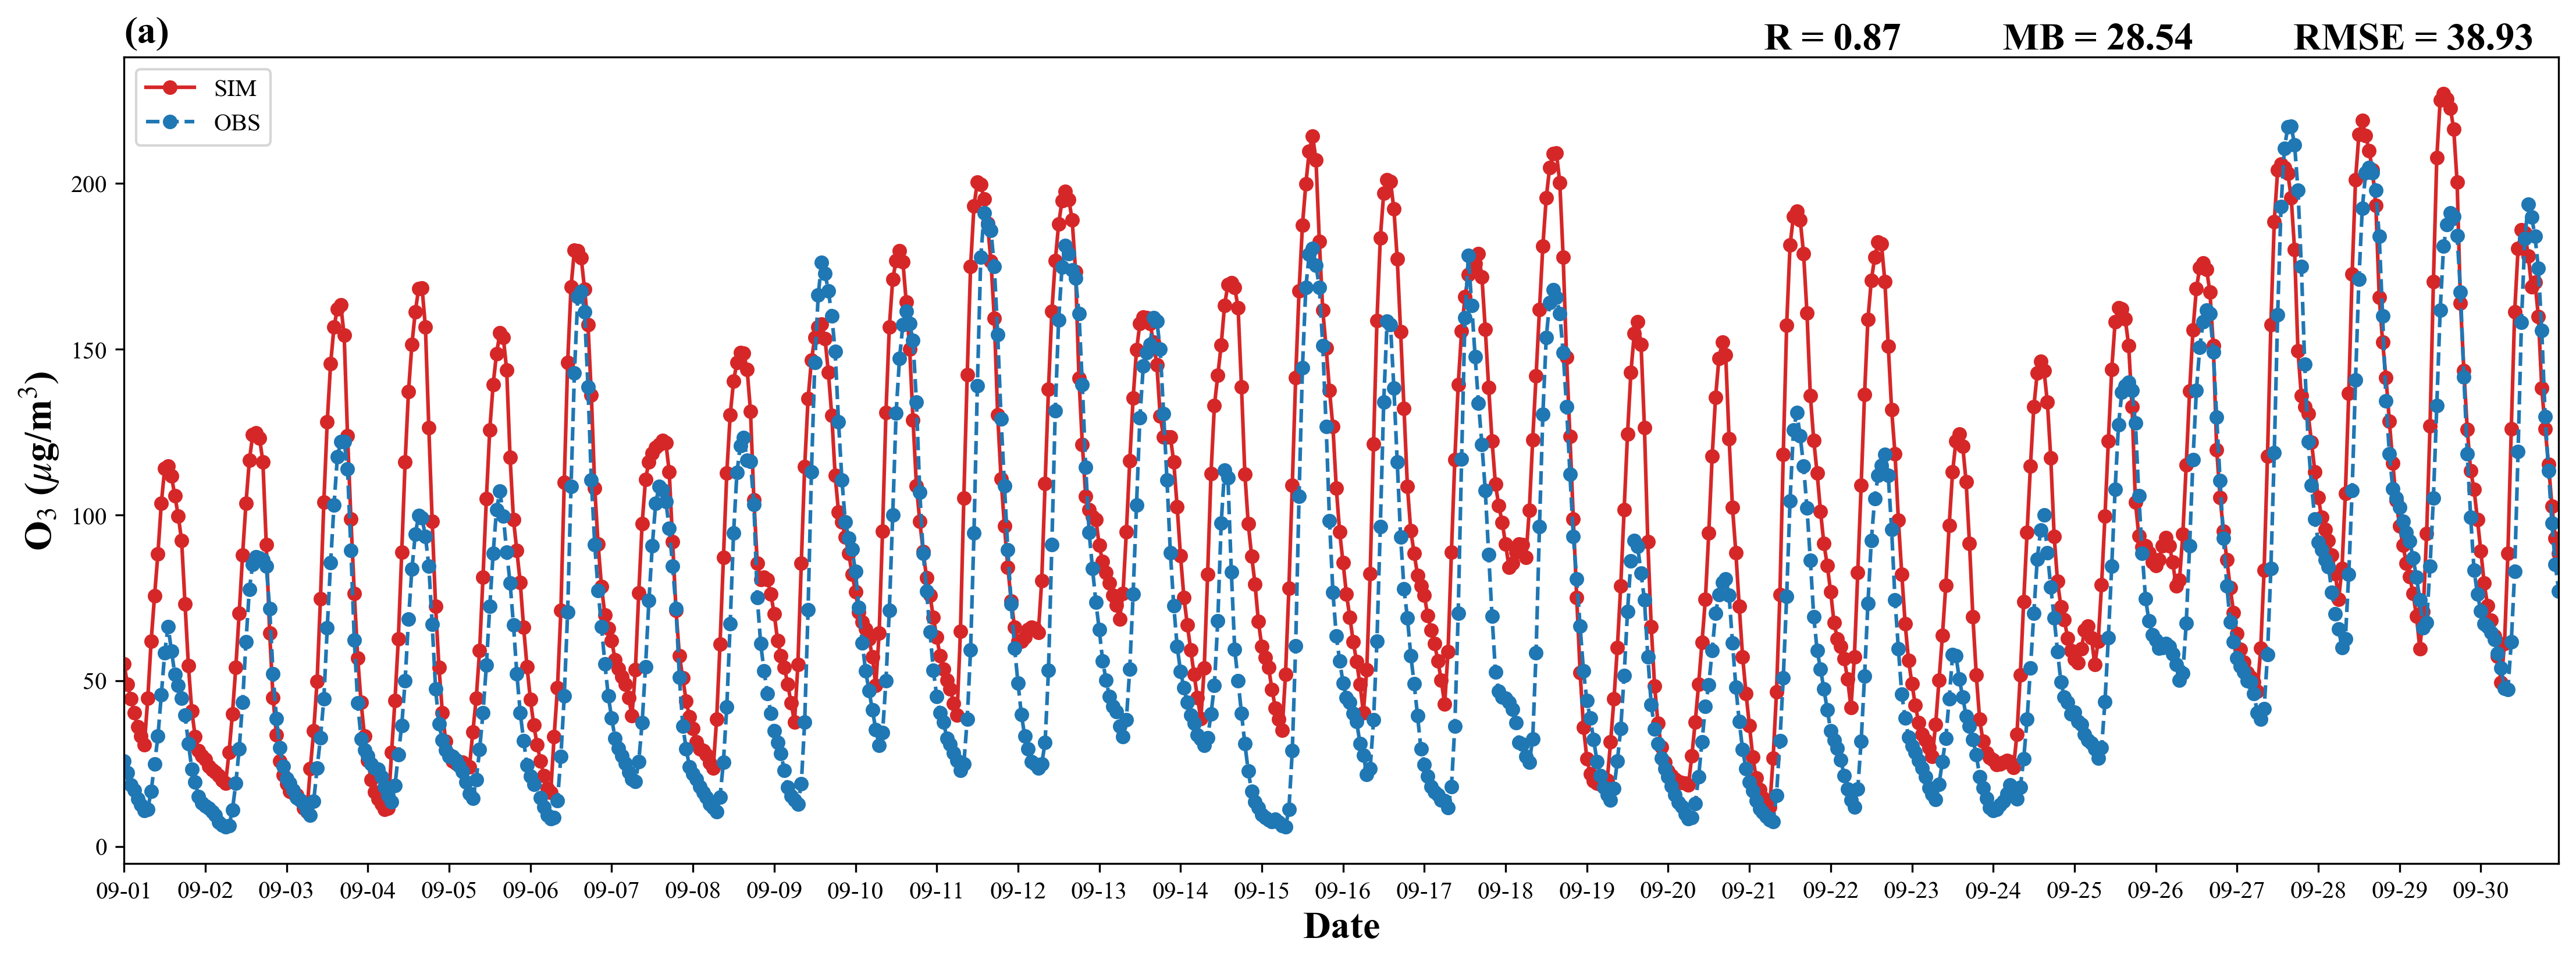

In [8]:
fig = plt.figure(figsize=(18,6),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,np.size(mean_obs,0),1)
ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

ax.set_xlim([0,np.size(mean_obs,0)-1])
ax.set_xticks(xx[::24])
ax.set_xticklabels(pd.date_range('2023-09-01','2023-09-30',freq='D').strftime('%m-%d'))#,rotation=45)

strdict = {'fontsize':16,'fontweight':'bold'}
ax.set_xlabel('Date',fontdict=strdict)
ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
ax.set_title('(a)',loc='left',fontdict=strdict)
ax.legend(loc=2)

# ===========
# add metrics
mb_str   = '{:.2f}'.format(mb)
r_str    = '{:.2f}'.format(r)
rmse_str = '{:.2f}'.format(rmse)

ax.text(0.73,1.01,f'R = {r_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
ax.text(0.85,1.01,f'MB = {mb_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
ax.text(0.99,1.01,f'RMSE = {rmse_str}',transform=ax.transAxes,fontdict=strdict,ha='right')

plt.show()

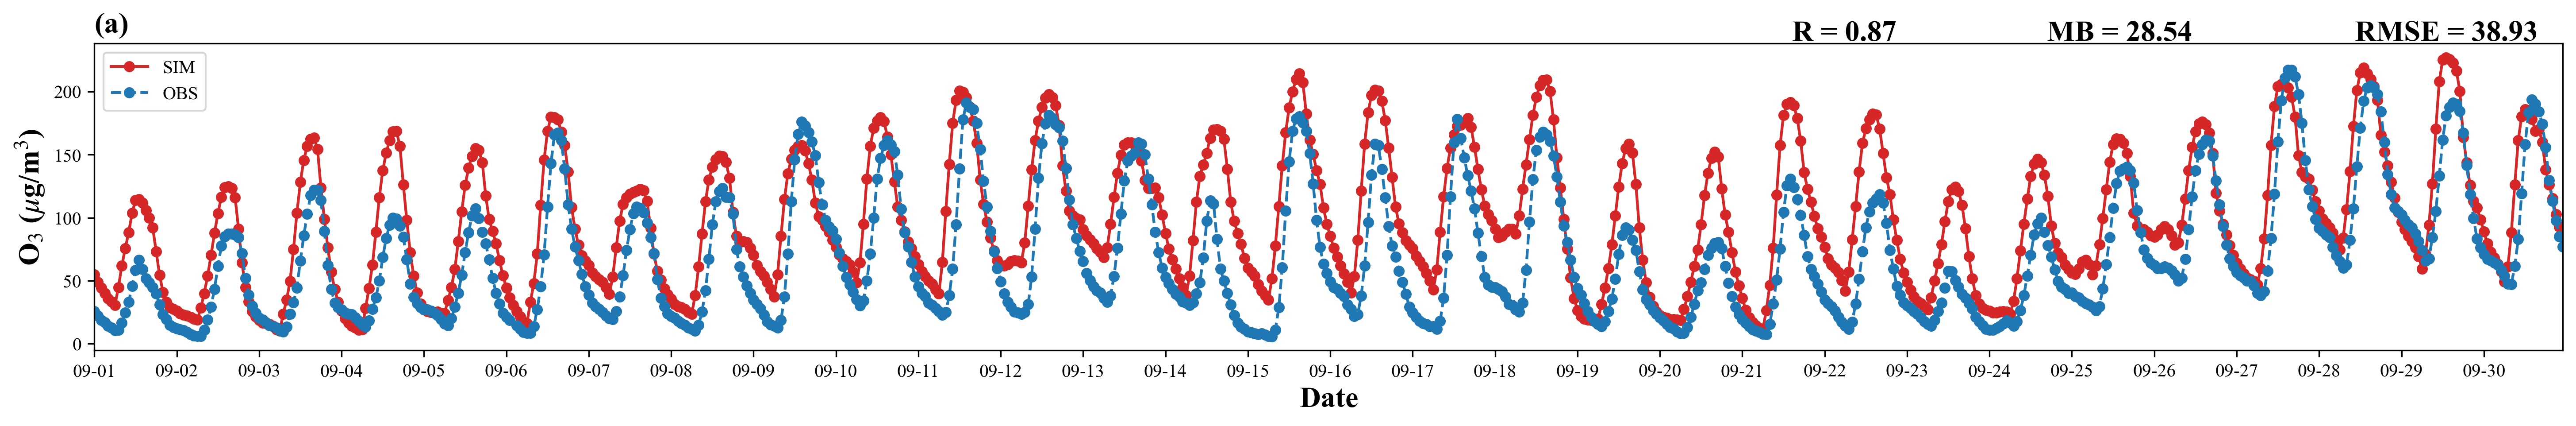

In [9]:
fig = plt.figure(figsize=(24,3),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,np.size(mean_obs,0),1)
ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

ax.set_xlim([0,np.size(mean_obs,0)-1])
ax.set_xticks(xx[::24])
ax.set_xticklabels(pd.date_range('2023-09-01','2023-09-30',freq='D').strftime('%m-%d'))#,rotation=45)

strdict = {'fontsize':16,'fontweight':'bold'}
ax.set_xlabel('Date',fontdict=strdict)
ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
ax.set_title('(a)',loc='left',fontdict=strdict)
ax.legend(loc=2)

# ===========
# add metrics
mb_str   = '{:.2f}'.format(mb)
r_str    = '{:.2f}'.format(r)
rmse_str = '{:.2f}'.format(rmse)

ax.text(0.73,1.01,f'R = {r_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
ax.text(0.85,1.01,f'MB = {mb_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
ax.text(0.99,1.01,f'RMSE = {rmse_str}',transform=ax.transAxes,fontdict=strdict,ha='right')

plt.show()